### Covid Analysis on John Hopkins Dataset
##### This project is submitted to the Spark + AI Summit 2020 #SparkAISummit. Currently, US is the country with the highest number of coronavirus cases in the whole world. This notebook visualises the trends and patterns of the COVID-19 disease in the United States from 12th April 2020 to 9th June 2020. We use Plotly for visualization and the Facebook's prophet module to forecast number of confirmed cases in different regions of the country.  

In [0]:
# Import important libraries

import pandas as pd
import numpy as np
import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import os

import logging, sys
logging.disable(sys.maxsize)


import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py

warnings.filterwarnings("ignore")
%matplotlib inline
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Load the dataset. Since I am using Google Colab, I have uploaded the data to my GDrive. To access the data from Gdrive, [here](https://https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674) is the link. This is a record of the daily count of different metrics from 12th April to 6th June for states and union territories in the US.

In [0]:
data_folder = "drive/My Drive/analysis_data/whole"
csv_files = glob.glob(data_folder+"/"+"*.csv")
population = pd.read_csv("drive/My Drive/analysis_data/population_2020.csv")

### Initial data preprocessing 
##### 1. Convert date to datetime object
##### 2. Get Week number and month number
##### 3. Filter data on country region as US
##### 4. Drop Unnecessary columns

In [14]:
df = pd.DataFrame()
for c in csv_files:
    d = pd.read_csv(c)
    d["date"] = c.split("/")[-1].split(".")[0]
    df = pd.concat([df,d])
df["date"] = pd.to_datetime(df["date"])
df['Week_Number'] = df['date'].dt.week
df["Month_Number"] = df["date"].dt.month
df = df[df["Country_Region"]=="US"]
df = df.drop(["Country_Region","Lat","Long_","Last_Update"],axis=1)
df = df[df.Province_State != "Recovered"]
print(df.shape)

(3422, 17)


In [15]:
df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,date,Week_Number,Month_Number
0,Alabama,9668,390,NaN,9278.0,1.0,206.189217,125494.0,1228.0,4.033926,84000001,USA,2676.407692,12.701696,2020-05-09,19,5
1,Alaska,378,10,318.0,50.0,2.0,63.237245,26449.0,NaN,2.645503,84000002,USA,4424.766917,NaN,2020-05-09,19,5
2,American Samoa,0,0,NaN,0.0,60.0,0.000000,83.0,NaN,NaN,16,ASM,149.170576,NaN,2020-05-09,19,5
3,Arizona,10960,532,2684.0,7744.0,4.0,150.575987,128940.0,1514.0,4.854015,84000004,USA,1771.466043,13.813869,2020-05-09,19,5
4,Arkansas,3747,88,2968.0,691.0,5.0,144.726185,65528.0,471.0,2.348546,84000005,USA,2530.989441,12.570056,2020-05-09,19,5


### Correlation Matrix for the features 
##### It shows that number of Deaths is highly correlated to number of Confirmed, Active cases and number of people hospitalized. 

In [16]:
df[["Confirmed","Deaths","Recovered","Active","Incident_Rate","People_Tested","People_Hospitalized","Mortality_Rate","Testing_Rate","Hospitalization_Rate"]].iloc[:,:].corr().style.background_gradient(cmap='Blues').format("{:.3f}")

,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
Confirmed,1.000,0.979,0.819,0.980,0.746,0.807,0.977,0.224,0.357,0.226
Deaths,0.979,1.000,0.798,0.946,0.739,0.725,0.983,0.253,0.352,0.237
Recovered,0.819,0.798,1.000,0.710,0.609,0.889,0.918,0.207,0.341,0.238
Active,0.980,0.946,0.710,1.000,0.727,0.783,0.959,0.207,0.314,0.223
Incident_Rate,0.746,0.739,0.609,0.727,1.000,0.503,0.728,0.206,0.614,0.103
People_Tested,0.807,0.725,0.889,0.783,0.503,1.000,0.858,0.123,0.398,0.218
People_Hospitalized,0.977,0.983,0.918,0.959,0.728,0.858,1.000,0.480,0.354,0.298
Mortality_Rate,0.224,0.253,0.207,0.207,0.206,0.123,0.480,1.000,0.200,0.526
Testing_Rate,0.357,0.352,0.341,0.314,0.614,0.398,0.354,0.200,1.000,-0.093
Hospitalization_Rate,0.226,0.237,0.238,0.223,0.103,0.218,0.298,0.526,-0.093,1.000


#### The next plot shows the trend of confirmed cases for different provinces
##### After week 23, the number of Confirmed cases in California began to rise over Washington

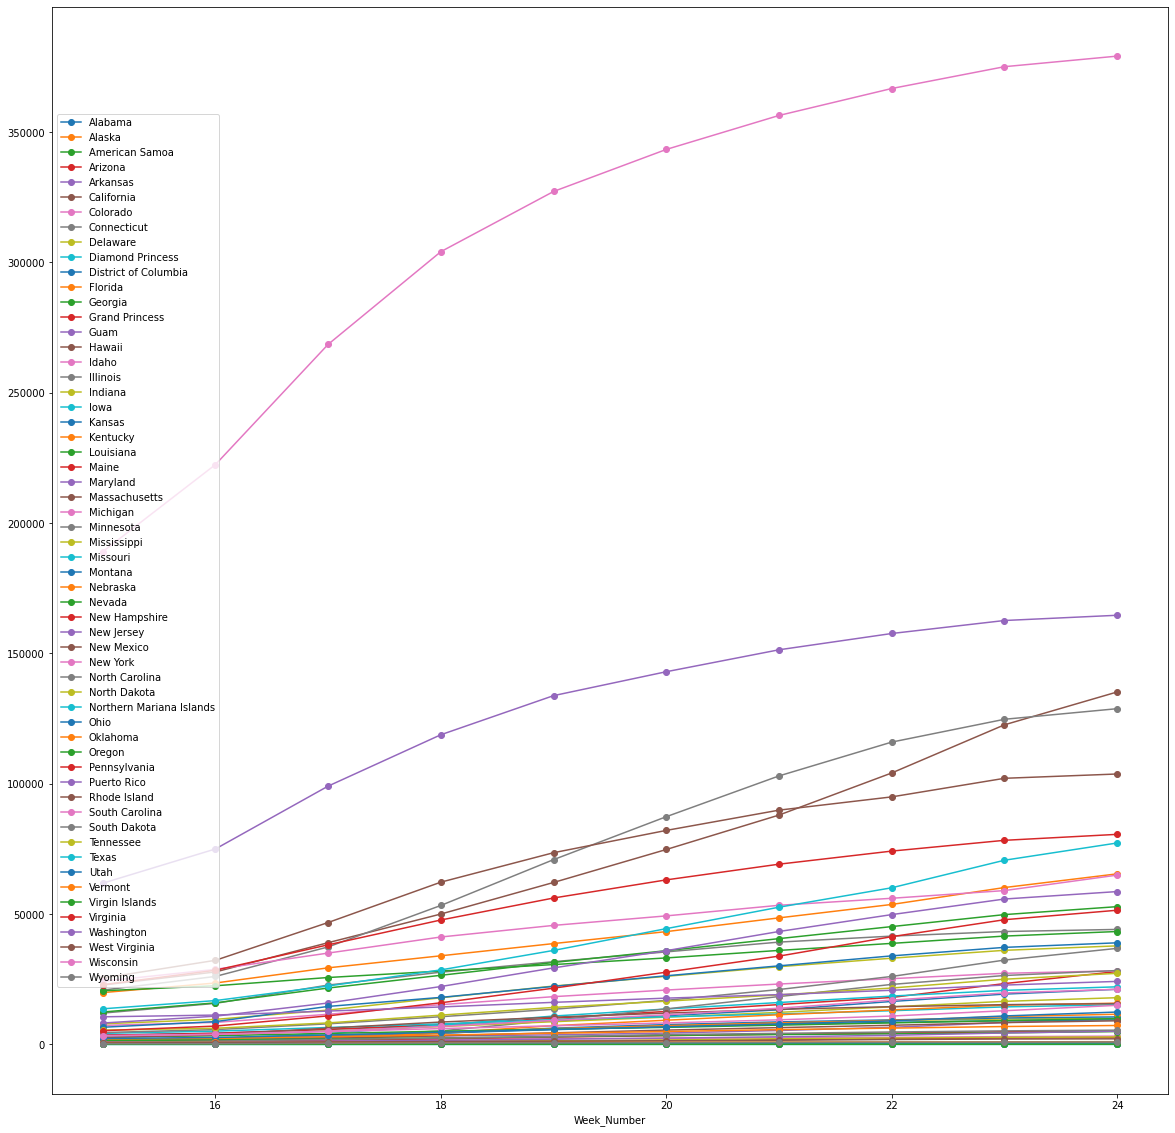

In [0]:
df.groupby(["Province_State","Week_Number"])["Confirmed"].mean().unstack('Province_State', fill_value=0).plot(linestyle='-', marker='o',figsize=(20,20))
plt.legend(loc="center left")
plt.show()

##### The next plot shows the top 10 states with the highest number of Confirmed, Active cases, Deaths and Recovered cases for the month of April

In [0]:
april_stats = df[df["Month_Number"]==4].sort_values("date").groupby("Province_State").last()
fig = make_subplots(rows=2, cols=2, start_cell="bottom-left", \
                    subplot_titles=("Recovered", "Deaths", "Active", "Confirmed"),horizontal_spacing = 0.2)

x1 = april_stats[["Active"]].sort_values("Active").index[-10:]
y1 = april_stats["Active"].sort_values().values[-10:]
x2 = april_stats[["Confirmed"]].sort_values("Confirmed").index[-10:]
y2 = april_stats["Confirmed"].sort_values().values[-10:]
x3 = april_stats[["Deaths"]].sort_values("Deaths").index[-10:]
y3 = april_stats["Deaths"].sort_values().values[-10:]
x4 = april_stats[["Recovered"]].sort_values("Recovered").index[-10:]
y4 = april_stats["Recovered"].sort_values().values[-10:]

fig.add_trace(go.Bar(
            x=y4,
            y=x4,
            orientation ="h",
            name="Recovered",
            marker_color='rgb(0, 255, 0)'),row=1, col=1)
            
fig.add_trace(go.Bar(
            x=y3,
            y=x3,
            orientation ="h",
            name="Deaths",
            marker_color='rgb(255, 0, 0)'),row=1, col=2)

fig.add_trace(go.Bar(
            x=y1,
            y=x1,
            orientation ="h",
            name="Active Cases",
            marker_color='rgb(55, 83, 109)'),row=2, col=1)

fig.add_trace(go.Bar(
            x=y2,
            y=x2,
            orientation ="h",
            name="Confirmed Cases"),row=2, col=2)

fig.update_layout(height=600, width=1000, title_text = "Top 10 States statistics for the month of April")

##### The next plot shows the top 10 states with the highest number of Confirmed, Active cases, Deaths and Recovered cases for the month of May

In [0]:
may_stats = df[df["Month_Number"]==5].sort_values("date").groupby("Province_State").last()
fig = make_subplots(rows=2, cols=2, start_cell="bottom-left", \
                    subplot_titles=("Recovered", "Deaths", "Active", "Confirmed"),horizontal_spacing = 0.2)

x1 = may_stats[["Active"]].sort_values("Active").index[-10:]
y1 = may_stats["Active"].sort_values().values[-10:]
x2 = may_stats[["Confirmed"]].sort_values("Confirmed").index[-10:]
y2 = may_stats["Confirmed"].sort_values().values[-10:]
x3 = may_stats[["Deaths"]].sort_values("Deaths").index[-10:]
y3 = may_stats["Deaths"].sort_values().values[-10:]
x4 = may_stats[["Recovered"]].sort_values("Recovered").index[-10:]
y4 = may_stats["Recovered"].sort_values().values[-10:]

fig.add_trace(go.Bar(
            x=y4,
            y=x4,
            orientation ="h",
            name="Recovered",
            marker_color='rgb(0, 255, 0)'),row=1, col=1)
            
fig.add_trace(go.Bar(
            x=y3,
            y=x3,
            orientation ="h",
            name="Deaths",
            marker_color='rgb(255, 0, 0)'),row=1, col=2)

fig.add_trace(go.Bar(
            x=y1,
            y=x1,
            orientation ="h",
            name="Active Cases",
            marker_color='rgb(55, 83, 109)'),row=2, col=1)

fig.add_trace(go.Bar(
            x=y2,
            y=x2,
            orientation ="h",
            name="Confirmed Cases"),row=2, col=2)

fig.update_layout(height=600, width=1000, title_text = "Top 10 States statistics for the month of April")

In [0]:
df = df.reset_index(drop=True)

##### For simplicity of plotting, we divide the states and union territories of the US into six regions

In [21]:
# Assign regions
north_east = "Maine, Massachusetts, Rhode Island, Connecticut, New Hampshire, Vermont, New York, Pennsylvania, New Jersey, Delaware, Maryland"
south_east = "West Virginia, Virginia, Kentucky, Tennessee, North Carolina, South Carolina, Georgia, Alabama, Mississippi, Arkansas, Louisiana, Florida"
mid_west = "Ohio, Indiana, Michigan, Illinois, Missouri, Wisconsin, Minnesota, Iowa, Kansas, Nebraska, South Dakota, North Dakota"
south_west = "Texas, Oklahoma, New Mexico, Arizona"
west = "Colorado, Wyoming, Montana, Idaho, Washington, Oregon, Utah, Nevada, California, Alaska, Hawaii"

north_east = north_east.split(", ")
south_east = south_east.split(", ")
mid_west = mid_west.split(", ")
south_west = south_west.split(", ")
west = west.split(", ")

province_states = list(df["Province_State"].unique())

territories = list(set(province_states) - set(north_east).union(set(south_east)).union(set(mid_west)).union(set(south_west)).union(set(west)))

def assign_region(state):
    if state in north_east:
        return "northeast"
    elif state in south_east:
        return "southeast"
    elif state in mid_west:
        return "midwest"
    elif state in south_west:
        return "southwest"
    elif state in west:
        return "west"
    elif state in territories:
        return "territory"

df["region"] = df["Province_State"].apply(assign_region)

df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,date,Week_Number,Month_Number,region
0,Alabama,9668,390,NaN,9278.0,1.0,206.189217,125494.0,1228.0,4.033926,84000001,USA,2676.407692,12.701696,2020-05-09,19,5,southeast
1,Alaska,378,10,318.0,50.0,2.0,63.237245,26449.0,NaN,2.645503,84000002,USA,4424.766917,NaN,2020-05-09,19,5,west
2,American Samoa,0,0,NaN,0.0,60.0,0.000000,83.0,NaN,NaN,16,ASM,149.170576,NaN,2020-05-09,19,5,territory
3,Arizona,10960,532,2684.0,7744.0,4.0,150.575987,128940.0,1514.0,4.854015,84000004,USA,1771.466043,13.813869,2020-05-09,19,5,southwest
4,Arkansas,3747,88,2968.0,691.0,5.0,144.726185,65528.0,471.0,2.348546,84000005,USA,2530.989441,12.570056,2020-05-09,19,5,southeast


##### This plot shows the regionwise trend of Incident Rate for the given time period. We notice similar valleys in the incident rate during the time between May 12 - May 14th in all the regions

In [0]:
region_rate = df[~df["Incident_Rate"].isnull()].groupby(["date","region"])["Incident_Rate"].sum().unstack().reset_index()
fig = make_subplots(rows=3, cols=2, start_cell="bottom-left",\
                    subplot_titles=("North East", "South East", "MidWest", "SouthWest","West","Territories"),horizontal_spacing = 0.05)

fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['northeast'], name="northeast"), row=1, col=1)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['southeast'], name="southeast"), row=1, col=2)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['midwest'], name="midwest"), row=2, col=1)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['southwest'], name="southwest"), row=2, col=2)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['west'], name="west"), row=3, col=1)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['territory'], name="territories"), row=3, col=2)

fig.update_layout(height=600, width=1000, title_text = "Regionwise trend in incident rate")
fig.show()

##### This plot shows the regionwise trend of Mortality Rate for the given time period. There is a unique trend in mortality rate in union territories compared to other regions where we notice a significant rise between June 4th to June 6th

In [0]:
region_rate = df[~df["Mortality_Rate"].isnull()].groupby(["date","region"])["Mortality_Rate"].sum().unstack().reset_index()
fig = make_subplots(rows=3, cols=2, start_cell="bottom-left",\
                    subplot_titles=("North East", "South East", "MidWest", "SouthWest","West","Territories"),horizontal_spacing = 0.05)

fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['northeast'], name="northeast"), row=1, col=1)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['southeast'], name="southeast"), row=1, col=2)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['midwest'], name="midwest"), row=2, col=1)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['southwest'], name="southwest"), row=2, col=2)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['west'], name="west"), row=3, col=1)
fig.add_trace(go.Scatter(x = region_rate['date'], y = region_rate['territory'], name="territories"), row=3, col=2)

fig.update_layout(height=600, width=1000, title_text = "Regionwise trend in mortality rate")
fig.show()

##### Adding population data to all the states and computing the Tested positive rate, states of New Jersey, District of Columbia, Massachusetts, Maryland, Pennsylvania, New York show 14-16% of positive cases among the entire respective state populations

In [0]:
state_wise = pd.merge(df.groupby("Province_State")[["People_Tested","Confirmed","Active","Recovered","Deaths","Testing_Rate", "Mortality_Rate","Hospitalization_Rate"]].last().reset_index(),population[["State","Pop"]], \
        left_on="Province_State",right_on="State", how="left").drop("State",axis=1)

state_wise.loc[state_wise["Province_State"]=="American Samoa","Pop"] = 55191
state_wise.loc[state_wise["Province_State"]=="Guam","Pop"] = 168775
state_wise.loc[state_wise["Province_State"]=="Northern Mariana Islands","Pop"] = 57559
state_wise.loc[state_wise["Province_State"]=="Virgin Islands","Pop"] = 104425

state_wise["Tested_positive_rate"] = state_wise["Confirmed"]/state_wise["People_Tested"]
state_wise.sort_values("Tested_positive_rate",ascending=False)


,Province_State,People_Tested,Confirmed,Active,Recovered,Deaths,Testing_Rate,Mortality_Rate,Hospitalization_Rate,Pop,Tested_positive_rate
44,Puerto Rico,5185.0,5185,5043.0,0.0,142,176.756864,2.738669,NaN,3032165.0,1.000000
34,New Jersey,989497.0,164796,124457.0,28036.0,12303,11140.236811,7.465594,10.964465,8936574.0,0.166545
10,District of Columbia,57152.0,9474,7836.0,1143.0,495,8098.063192,5.224826,12.538989,720687.0,0.165768
25,Massachusetts,661992.0,103889,96481.0,0.0,7408,9604.522479,7.130688,10.113679,6976597.0,0.156934
24,Maryland,378082.0,58904,51814.0,4279.0,2811,6253.754747,4.772172,16.426728,6083116.0,0.155797
43,Pennsylvania,536304.0,80870,21186.0,53670.0,6014,4189.224034,7.436627,7.660329,12820878.0,0.150791
36,New York,2605869.0,379482,281216.0,67808.0,30458,13395.331580,8.026204,23.715222,19440469.0,0.145626
8,Delaware,70753.0,10020,3722.0,5888.0,410,7265.928911,4.091816,8.406250,982895.0,0.141619
7,Connecticut,312651.0,44179,32798.0,7284.0,4097,8769.308053,9.273637,21.885964,3563077.0,0.141305
53,Virginia,390856.0,51738,43565.0,6677.0,1496,4579.170874,2.891492,15.164869,8626207.0,0.132371


##### The next plot shows the Regionwise trend in the number of new daily deaths. The Deaths seem to decrease in the Northeast region. Other regions show deaths in the range of 100-500

In [0]:
death_trend = df.groupby(["date","region"])["Deaths"].sum().unstack().diff().reset_index()
fig = make_subplots(rows=3, cols=2, start_cell="bottom-left",\
                    subplot_titles=("North East", "South East", "MidWest", "SouthWest","West","Territories"),horizontal_spacing = 0.05)

fig.add_trace(go.Scatter(x = death_trend['date'], y = death_trend['northeast'], name="northeast", mode="lines+markers"), row=1, col=1)
fig.add_trace(go.Scatter(x = death_trend['date'], y = death_trend['southeast'], name="southeast", mode="lines+markers"), row=1, col=2)
fig.add_trace(go.Scatter(x = death_trend['date'], y = death_trend['midwest'], name="midwest", mode="lines+markers"), row=2, col=1)
fig.add_trace(go.Scatter(x = death_trend['date'], y = death_trend['southwest'], name="southwest", mode="lines+markers"), row=2, col=2)
fig.add_trace(go.Scatter(x = death_trend['date'], y = death_trend['west'], name="west", mode="lines+markers"), row=3, col=1)
fig.add_trace(go.Scatter(x = death_trend['date'], y = death_trend['territory'], name="territories", mode="lines+markers"), row=3, col=2)

fig.update_layout(height=600, width=1000, title_text = "Regionwise trend in daily deaths")
fig.show()

###### Assign weekday according to date

In [0]:
df["WeekDay"] = df["date"].dt.day_name()
df.head()

,Province_State,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,date,Week_Number,Month_Number,region,WeekDay
0,Alabama,9668,390,NaN,9278.0,1.0,206.189217,125494.0,1228.0,4.033926,84000001,USA,2676.407692,12.701696,2020-05-09,19,5,southeast,Saturday
1,Alaska,378,10,318.0,50.0,2.0,63.237245,26449.0,NaN,2.645503,84000002,USA,4424.766917,NaN,2020-05-09,19,5,west,Saturday
2,American Samoa,0,0,NaN,0.0,60.0,0.000000,83.0,NaN,NaN,16,ASM,149.170576,NaN,2020-05-09,19,5,territory,Saturday
3,Arizona,10960,532,2684.0,7744.0,4.0,150.575987,128940.0,1514.0,4.854015,84000004,USA,1771.466043,13.813869,2020-05-09,19,5,southwest,Saturday
4,Arkansas,3747,88,2968.0,691.0,5.0,144.726185,65528.0,471.0,2.348546,84000005,USA,2530.989441,12.570056,2020-05-09,19,5,southeast,Saturday


##### Prepare dataset for forecating according to fbprophet requirements

In [23]:
ts = df.copy()
ts.index = ts["date"]
ts.index = ts.index.rename("ds")
ts.head()

,Province_State,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate,date,Week_Number,Month_Number,region
ds,,,,,,,,,,,,,,,,,,
2020-05-09,Alabama,9668,390,NaN,9278.0,1.0,206.189217,125494.0,1228.0,4.033926,84000001,USA,2676.407692,12.701696,2020-05-09,19,5,southeast
2020-05-09,Alaska,378,10,318.0,50.0,2.0,63.237245,26449.0,NaN,2.645503,84000002,USA,4424.766917,NaN,2020-05-09,19,5,west
2020-05-09,American Samoa,0,0,NaN,0.0,60.0,0.000000,83.0,NaN,NaN,16,ASM,149.170576,NaN,2020-05-09,19,5,territory
2020-05-09,Arizona,10960,532,2684.0,7744.0,4.0,150.575987,128940.0,1514.0,4.854015,84000004,USA,1771.466043,13.813869,2020-05-09,19,5,southwest
2020-05-09,Arkansas,3747,88,2968.0,691.0,5.0,144.726185,65528.0,471.0,2.348546,84000005,USA,2530.989441,12.570056,2020-05-09,19,5,southeast


#### Regionwise total confirmed cases pivot table

In [24]:
ts_pivot_reg = pd.pivot_table(ts[["region","Confirmed"]],index="ds", columns="region", values="Confirmed", aggfunc=sum)
ts_pivot_reg.head()

region,midwest,northeast,southeast,southwest,territory,west
ds,,,,,,
2020-04-12,73619,326135,81794,20434,3119,50212
2020-04-13,77671,340663,85699,21311,3205,52070
2020-04-14,81623,356520,89625,22344,3328,54230
2020-04-15,85660,374875,92688,23618,3522,55987
2020-04-16,89769,394423,97130,24954,3744,57781


###### Forecasting on confirmed cases for the next 15 days using Fbprophet. According to the evaluation metrics, the forecast for the region Northeast performs better than all the other regions. Forecast for midwest region performs the worst

In [0]:
regions = list(ts_pivot_reg.columns)

for r in regions: 
  train_dataset= ts_pivot_reg[r].diff().reset_index()
  train_dataset.columns = ["ds","y"]
  prophet_basic = Prophet()
  prophet_basic.fit(train_dataset)
  models.append(prophet_basic)
  future = prophet_basic.make_future_dataframe(periods=15)
  futures.append(future)
  forecast = prophet_basic.predict(future)
  forecasts.append(forecast)
  metric_df = forecast.set_index('ds')[['yhat']].join(train_dataset.set_index('ds').y).reset_index()
  metric_df.dropna(inplace=True)
  print("Model for "+r)
  print("R2 score :- ",r2_score(metric_df.y, metric_df.yhat))
  print("Mean squared error :- ",mean_squared_error(metric_df.y, metric_df.yhat))
  print("Mean absolute error :- ",mean_absolute_error(metric_df.y, metric_df.yhat))
  print("\n")


Model for midwest
R2 score :-  0.25189368180198346
Mean squared error :-  1436144.5081407877
Mean absolute error :-  987.1181192904452


Model for northeast
R2 score :-  0.9070566361767526
Mean squared error :-  2152815.4960678495
Mean absolute error :-  1080.8723063821517


Model for southeast
R2 score :-  0.7003942016585434
Mean squared error :-  314708.2451306267
Mean absolute error :-  452.2420677244528


Model for southwest
R2 score :-  0.5884583054111338
Mean squared error :-  183706.96420683083
Mean absolute error :-  313.5578732028303


Model for territory
R2 score :-  0.3394870983320306
Mean squared error :-  5362.797906387219
Mean absolute error :-  55.83008511183862


Model for west
R2 score :-  0.5585261531052588
Mean squared error :-  242984.72407461607
Mean absolute error :-  417.93252796283724




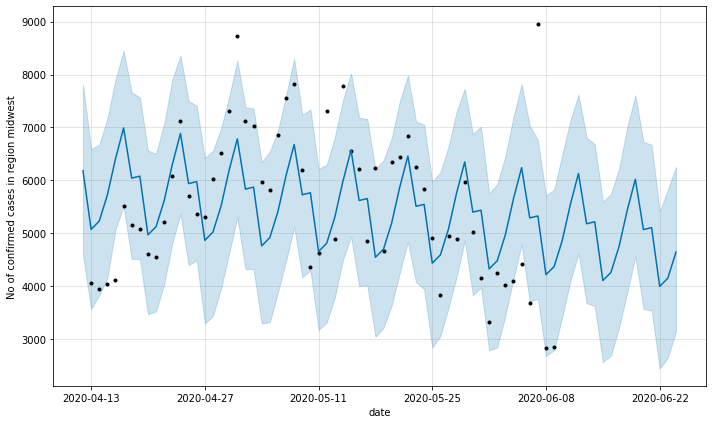

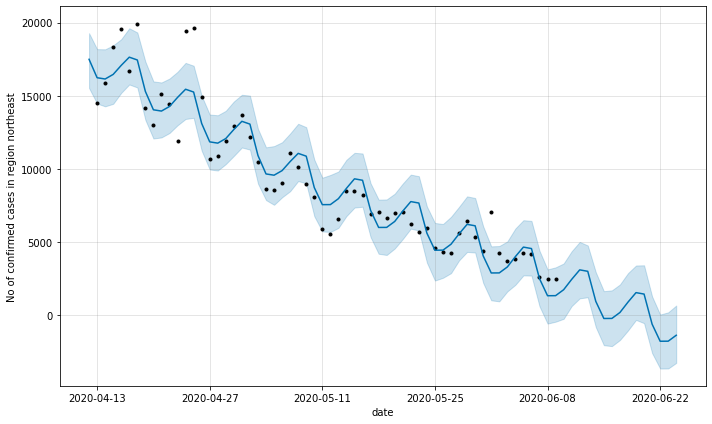

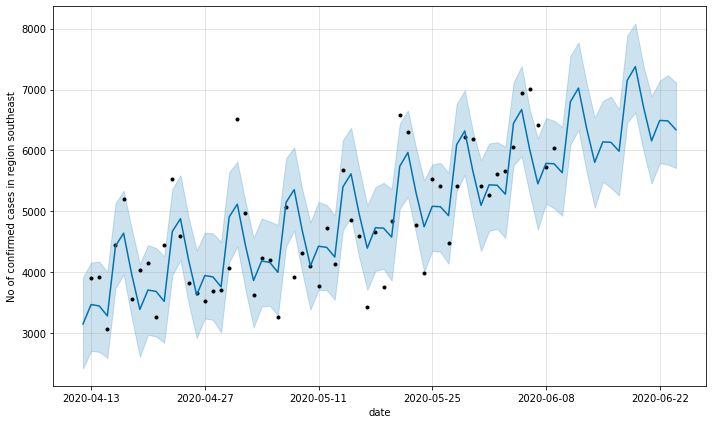

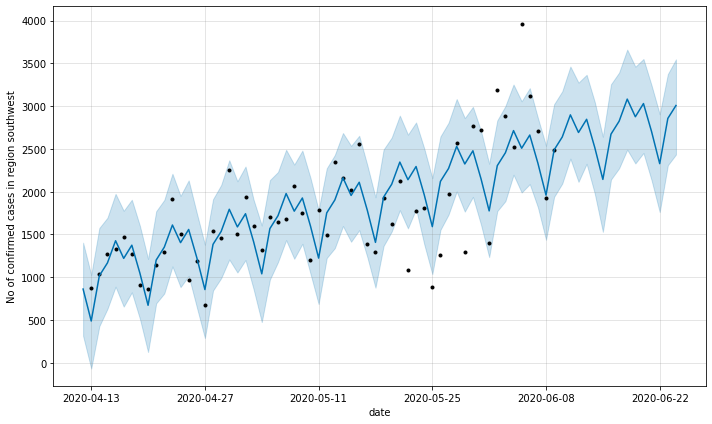

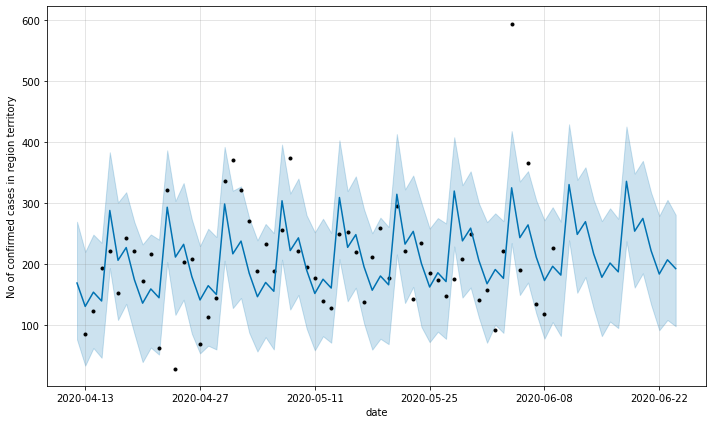

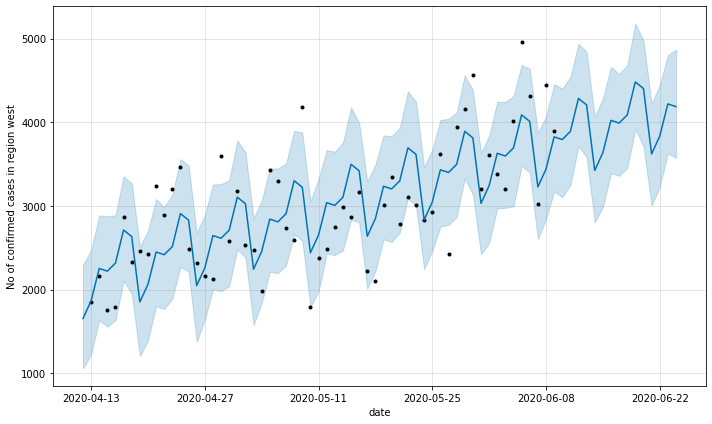

In [0]:
for i in range(len(regions)):
  model = models[i]
  title = "Forecasting number of confirmed cases in the region "+regions[i]
  model.plot(forecasts[i],xlabel="date",ylabel="No of confirmed cases in region {}".format(regions[i]))

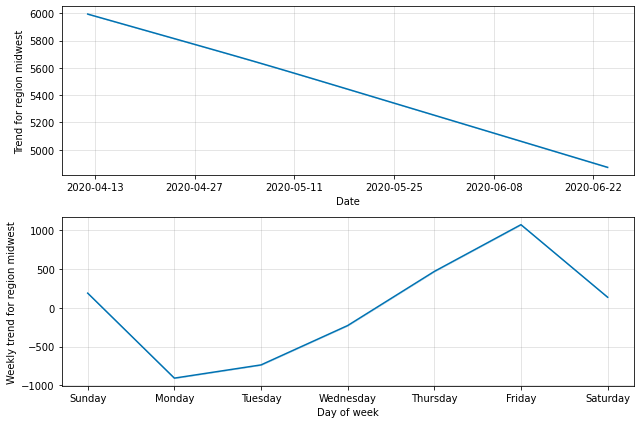

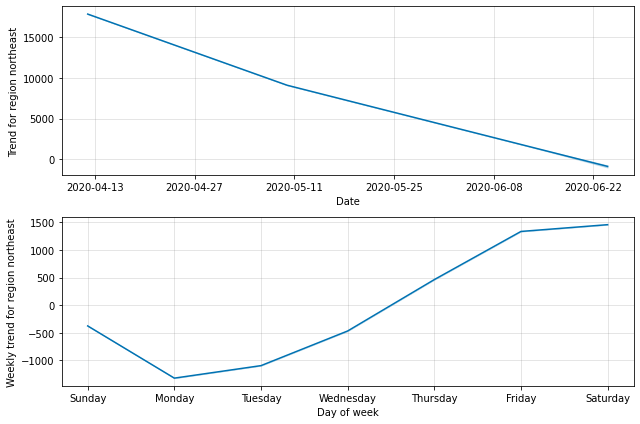

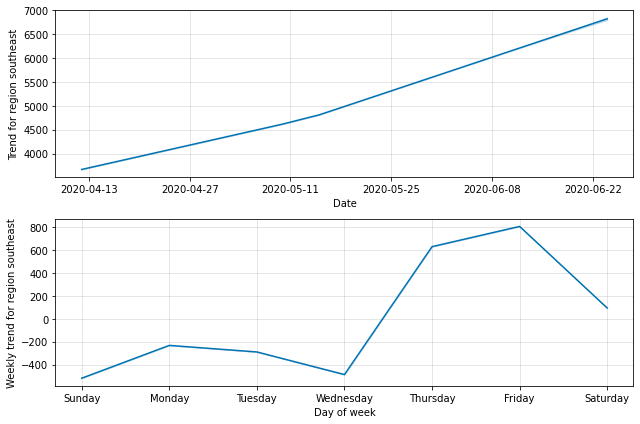

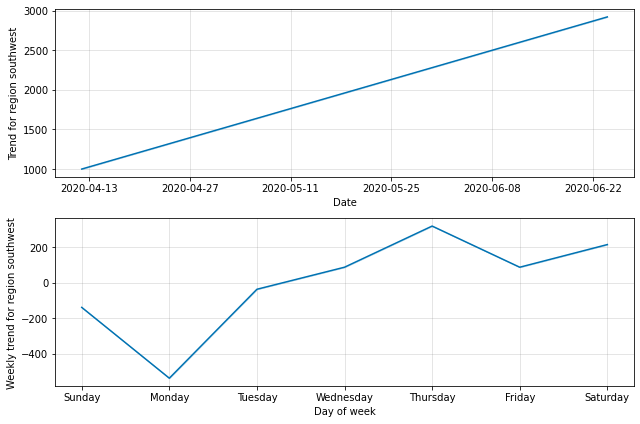

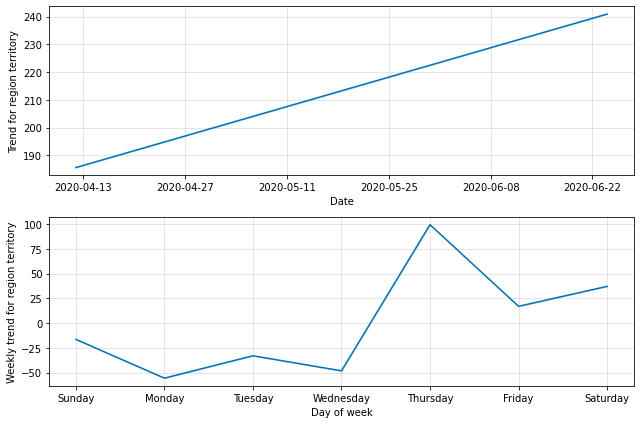

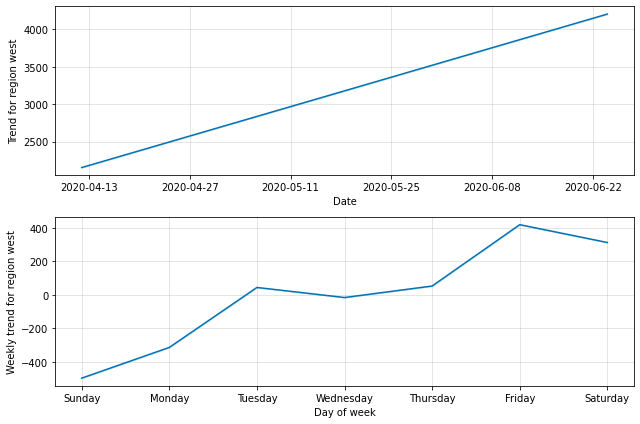

In [0]:
for i in range(len(regions)):
  model = models[i]
  title = "Forecasting number of confirmed cases in the region "+regions[i]
  components_fig = model.plot_components(forecasts[i])
  axes = components_fig.get_axes()
  axes[0].set_ylabel("Trend for region {}".format(regions[i]))
  axes[0].set_xlabel('Date')
  axes[1].set_ylabel("Weekly trend for region {}".format(regions[i]))
# fig2 = prophet_basic.plot_components(forecast)

##### We can see that for every region, the confirmed cases trends spikes mostly during the end of the week mainly between Thursday to Saturday.